In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'ConSTRain-analyses' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

## Check mreps repeats

mreps randomly replaces 'N' characters in the input sequence with A, C, G, or T. This has a chance to introduce artificial repeats that do not exist in the reference genome. This is even more of a concern since we are interested in mononucleotide repeats.

To address this, we check for every mreps mononucleotide whether the annotated sequences fully matches the specified region in the reference genome.

In [6]:
%%time
chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]

df_mreps = []
for chrom in chromosomes:
    mreps_file = f"../../data/repeats/{chrom}_mreps.txt"
    df_mreps_chrom = file_io.load_mreps_repeats(mreps_file, chrom)
    df_mreps.append(df_mreps_chrom)

# Add all mreps DFs together, and substract 1 from start position to convert to 0-based open-ended coordinates
df_mreps = pd.concat(df_mreps).assign(start = lambda x: x["start"] - 1).reset_index(drop=True)
df_mreps

CPU times: user 3.59 s, sys: 426 ms, total: 4.01 s
Wall time: 4.05 s


,str_id,chr,start,end,unit,period,ref
0,chr1_28589,chr1,28588,28603,T,1,15
1,chr1_31720,chr1,31719,31733,A,1,14
2,chr1_33450,chr1,33449,33464,A,1,15
3,chr1_33531,chr1,33530,33541,T,1,11
4,chr1_36352,chr1,36351,36364,A,1,13
...,...,...,...,...,...,...,...
1015880,chrY_57188868,chrY,57188867,57188878,A,1,11
1015881,chrY_57200838,chrY,57200837,57200851,A,1,14
1015882,chrY_57201000,chrY,57200999,57201019,A,1,20
1015883,chrY_57202381,chrY,57202380,57202403,A,1,23


In [9]:
%%time
parser = SeqIO.parse("../../data/reference/hg38.fa", "fasta")
matches_ref = []
df_mismatches = {
    "str_id": [],
    "mreps_seq": [],
    "ref_seq": [],
}

for record in parser:
    if record.id not in chromosomes:
        continue
    df_chrom = df_mreps.query(f"chr == '{record.id}'")
    for repeat in df_chrom.to_dict(orient="records"):
        mreps_seq = repeat["unit"] * repeat["ref"]
        ref_seq = str(record.seq[repeat["start"]:repeat["end"]]).upper() # BioPython slicing is BED-like
        match = mreps_seq == ref_seq
        matches_ref.append(match)
        if not match:
            df_mismatches["str_id"].append(repeat["str_id"])            
            df_mismatches["mreps_seq"].append(mreps_seq)
            df_mismatches["ref_seq"].append(ref_seq)
            
matches_ref = np.array(matches_ref)
df_mismatches = pd.DataFrame(df_mismatches)

CPU times: user 22.1 s, sys: 4.87 s, total: 26.9 s
Wall time: 27 s


In [10]:
print(f"{df_mismatches.shape[0]} / {df_mreps.shape[0]} repeats were artifacts generated by mreps")
df_mismatches

241 / 1015885 repeats were artifacts generated by mreps


,str_id,mreps_seq,ref_seq
0,chr1_122026432,GGGGGGGGGG,NNNNNNNNNN
1,chr1_125723976,GGGGGGGGGG,NNNNNNNNNN
2,chr1_125829450,CCCCCCCCCC,NNNNNNNNNN
3,chr1_126642074,TTTTTTTTTT,NNNNNNNNNN
4,chr1_127093359,AAAAAAAAAA,NNNNNNNNNN
...,...,...,...
236,chrY_54871197,CCCCCCCCCCC,NNNNNNNNNNN
237,chrY_55112936,AAAAAAAAAAA,NNNNNNNNNNN
238,chrY_55937004,CCCCCCCCCC,NNNNNNNNNN
239,chrY_56016232,AAAAAAAAAAAAA,NNNNNNNNNNNNN


In [11]:
df_mreps = df_mreps.loc[matches_ref].reset_index(drop=True)
df_mreps

,str_id,chr,start,end,unit,period,ref
0,chr1_28589,chr1,28588,28603,T,1,15
1,chr1_31720,chr1,31719,31733,A,1,14
2,chr1_33450,chr1,33449,33464,A,1,15
3,chr1_33531,chr1,33530,33541,T,1,11
4,chr1_36352,chr1,36351,36364,A,1,13
...,...,...,...,...,...,...,...
1015639,chrY_57188868,chrY,57188867,57188878,A,1,11
1015640,chrY_57200838,chrY,57200837,57200851,A,1,14
1015641,chrY_57201000,chrY,57200999,57201019,A,1,20
1015642,chrY_57202381,chrY,57202380,57202403,A,1,23


## Load GangSTR panel, merge with mreps repeats, remove repeats with neighbours

Now that we have removed mreps artifacts from our set of mononucleotide repeats, we load the GangSTR v13 STR panel. The two panels will be merged, and repeats that have close neighbouring repeats will be removed (although we will make sure to keep all repeats that are in the GangSTR panel).

In [12]:
df_gangstr = pd.read_csv("../../data/hg38_ver13_0boe.bed", sep="\t", names=["chr", "start", "end", "period", "unit"])
df_gangstr

,chr,start,end,period,unit
0,chr1,14069,14081,4,CCTC
1,chr1,16619,16631,3,GCT
2,chr1,22811,22821,5,AGGAA
3,chr1,26453,26465,2,GT
4,chr1,31555,31570,5,AAAAT
...,...,...,...,...,...
832375,chrY,56885930,56885946,4,TAAA
832376,chrY,56886167,56886179,4,GAAA
832377,chrY,56886703,56886715,4,AATG
832378,chrY,56886965,56886977,4,TTTC


Merge with the mononucleotides detected by mreps (keep track of which repeats are part of the original GangSTR panel)

In [13]:
df_merged = pd.concat([
    df_gangstr.assign(is_gangstr_str = True), 
    df_mreps[["chr", "start", "end", "period", "unit"]].assign(is_gangstr_str = False)
]).reset_index(drop=True)
df_merged

,chr,start,end,period,unit,is_gangstr_str
0,chr1,14069,14081,4,CCTC,True
1,chr1,16619,16631,3,GCT,True
2,chr1,22811,22821,5,AGGAA,True
3,chr1,26453,26465,2,GT,True
4,chr1,31555,31570,5,AAAAT,True
...,...,...,...,...,...,...
1848019,chrY,57188867,57188878,1,A,False
1848020,chrY,57200837,57200851,1,A,False
1848021,chrY,57200999,57201019,1,A,False
1848022,chrY,57202380,57202403,1,A,False


Check for which repeats there is another repeat within 50 bp on either side

In [25]:
# If there is another repeat within 'flanksize' before or after a repeat, it counts as a neighbour
flanksize = 50

df_merged_neighbour = []
for chrom, data in df_merged.groupby("chr"):
    data = data.sort_values("start") # sorting is essential here
    
    dist_to_prev = data["start"] - np.roll(data["end"], 1)
    dist_to_prev.iloc[0]= np.nan
    
    dist_to_next = np.roll(data["start"], -1) - data["end"]
    dist_to_next.iloc[-1] = np.nan

    data = data.assign(
        # TODO: check this!
        has_neighbour = lambda x: [i < flanksize or j < flanksize for i, j in zip(dist_to_prev, dist_to_next)]
    )
    df_merged_neighbour.append(data)
df_merged_neighbour = pd.concat(df_merged_neighbour).reset_index(drop=True)

df_merged_neighbour

,chr,start,end,period,unit,is_gangstr_str,has_neighbour
0,chr1,14069,14081,4,CCTC,True,False
1,chr1,16619,16631,3,GCT,True,False
2,chr1,22811,22821,5,AGGAA,True,False
3,chr1,26453,26465,2,GT,True,False
4,chr1,28588,28603,1,T,False,False
...,...,...,...,...,...,...,...
1848019,chrY,57188867,57188878,1,A,False,False
1848020,chrY,57200837,57200851,1,A,False,False
1848021,chrY,57200999,57201019,1,A,False,False
1848022,chrY,57202380,57202403,1,A,False,False


Remove repeats that have a neighbour, however always preserve those repeats that are part of the original GangSTR panel

In [26]:
df_merged_filt = df_merged_neighbour[~df_merged_neighbour["has_neighbour"] | df_merged_neighbour["is_gangstr_str"]].reset_index(drop=True)

print(df_merged_filt[df_merged_filt["has_neighbour"]]["is_gangstr_str"].sum())
print(df_merged_filt[df_merged_filt["has_neighbour"]].shape)
print(df_merged_neighbour.shape[0] - df_merged_filt.shape[0])

df_merged_filt = df_merged_filt.drop(["has_neighbour", "is_gangstr_str"], axis=1)
df_merged_filt

57319
(57319, 7)
114378


,chr,start,end,period,unit
0,chr1,14069,14081,4,CCTC
1,chr1,16619,16631,3,GCT
2,chr1,22811,22821,5,AGGAA
3,chr1,26453,26465,2,GT
4,chr1,28588,28603,1,T
...,...,...,...,...,...
1733641,chrY,57188867,57188878,1,A
1733642,chrY,57200837,57200851,1,A
1733643,chrY,57200999,57201019,1,A
1733644,chrY,57202380,57202403,1,A


In [27]:
# df_merged_filt.to_csv("../../data/hg38_ver13_0boe_mononucleotides.bed", header=False, index=False, sep="\t")

In [28]:
df_plot = (
    df_merged_filt[["period", "start"]]
         # .query("period <= 6")
         .groupby("period", as_index=False)
         .agg(count = ("start", "count"))
         .assign(frac = lambda x: x["count"] / x["count"].sum())
)
df_plot

,period,count,frac
0,1,901266,0.519867
1,2,123354,0.071153
2,3,142800,0.082370
3,4,345129,0.199077
4,5,164735,0.095022
5,6,35881,0.020697
6,7,8783,0.005066
7,8,5547,0.003200
8,9,1956,0.001128
9,10,1287,0.000742


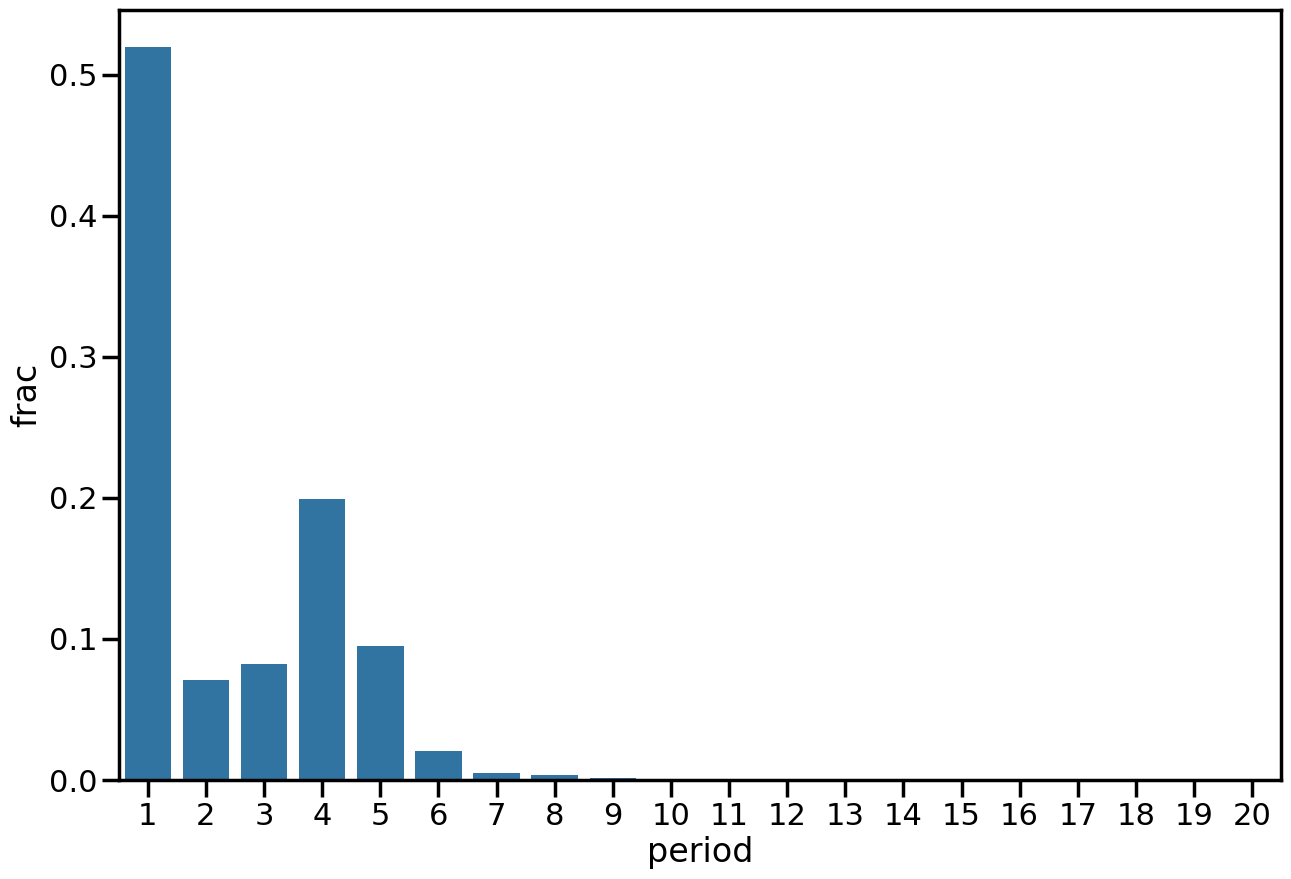

In [29]:
fig = plt.figure(figsize=(15, 10))

ax = sns.barplot(
    df_plot,
    x="period",
    y="frac"
)


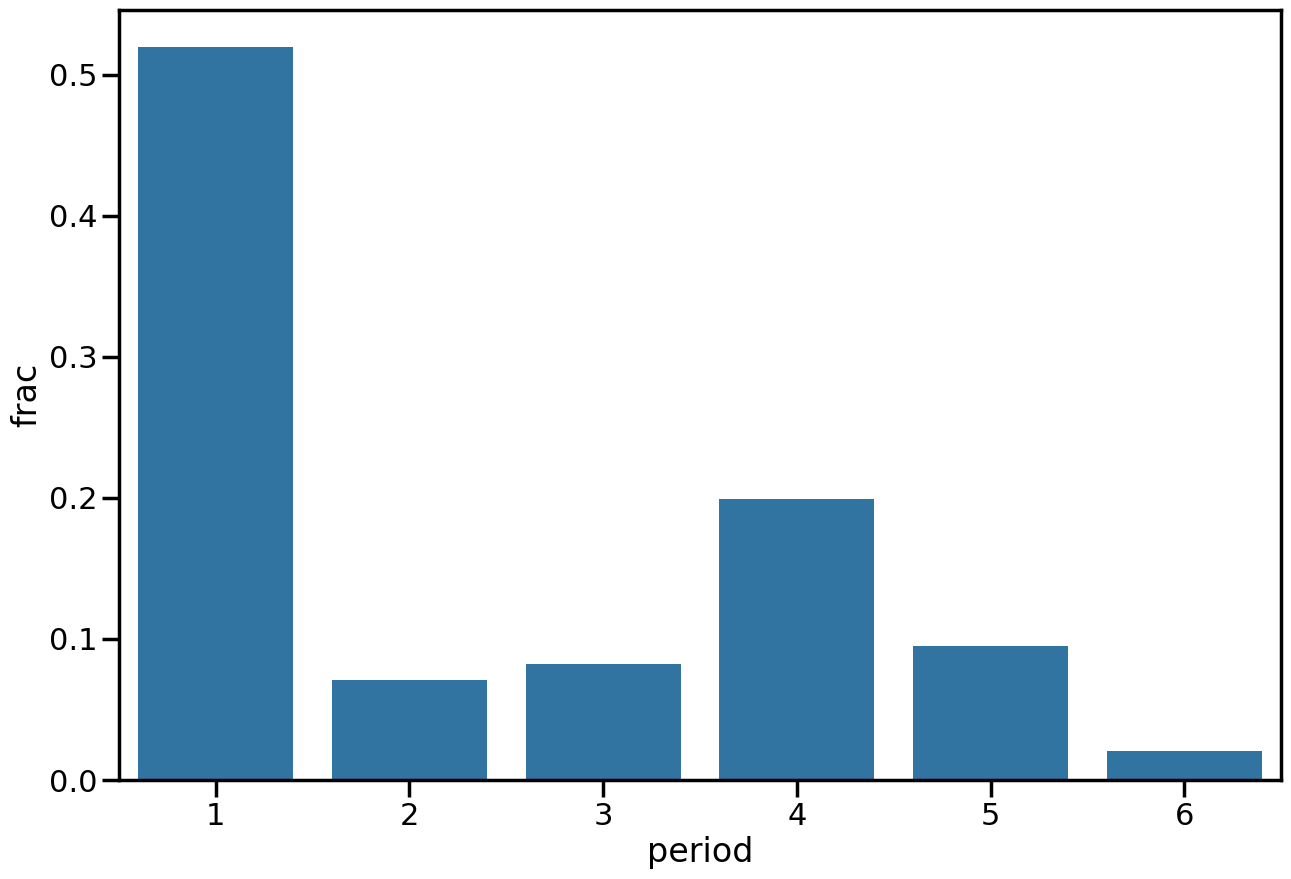

In [30]:
fig = plt.figure(figsize=(15, 10))

ax = sns.barplot(
    df_plot.query("period <= 6"),
    x="period",
    y="frac"
)



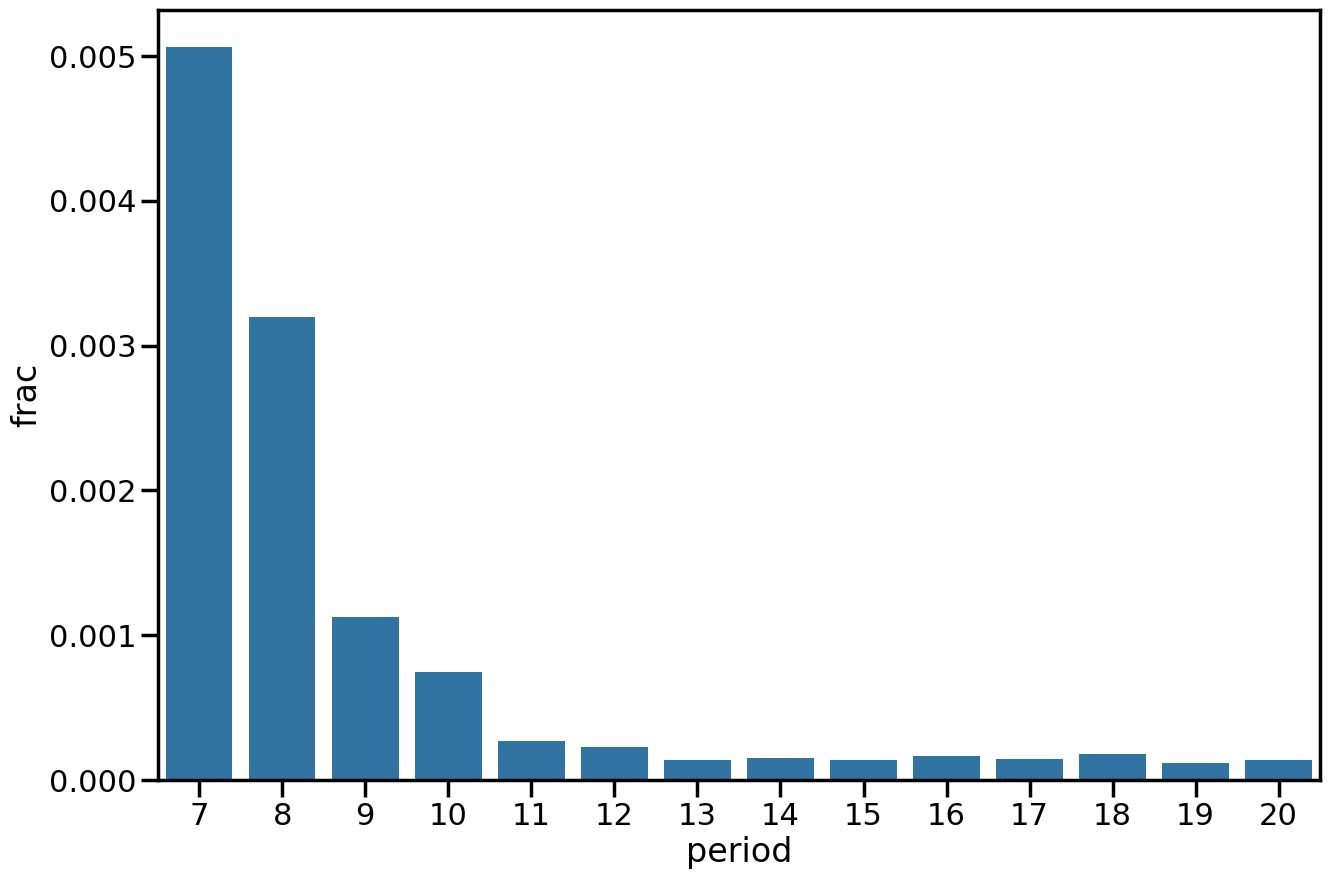

In [31]:
fig = plt.figure(figsize=(15, 10))

ax = sns.barplot(
    df_plot.query("period > 6"),
    x="period",
    y="frac"
)

